### 利用鸢尾花数据集，实现前向传播、反向传播，可视化loss曲线

In [1]:
# 导入所需模块
import tensorflow as tf
from sklearn import datasets
from matplotlib import pyplot as plt
import numpy as np
%pylab inline
# jupyter 进行matplotlib 展示需要引入

Populating the interactive namespace from numpy and matplotlib


In [2]:
SEED = 666 # 设置随机化种子，全局一致
LEARNING_RATE = 0.01 # 学习率
# 导入数据，分别为输入特征和标签
x_data = datasets.load_iris().data   # 导入鸢尾花数据
y_data = datasets.load_iris().target # 鸢尾花数据集标签

# 随机打乱数据，注意使用相同的种子，以便数据和标签一一对应
np.random.seed(SEED)
np.random.shuffle(x_data)
np.random.seed(SEED)
np.random.shuffle(y_data)
tf.random.set_seed(SEED)

In [3]:
# 将打乱后的顺序分割为训练集和测试集，训练集是前120行数据，测试集是后30行数据
x_train = x_data[:-30]
y_train = y_data[:-30]
x_test = x_data[-30:]
y_test = y_data[-30:]

使用TF的 `cast` 函数转换数据类型，否则后面矩阵相乘时会因数据类型不一致报错

```(python)
tf.cast(
    x, dtype, name=None
)
```

In [4]:
x_train = tf.cast(x_train, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)

切分传入张量的第一维度，生成输入特征/标签对，构造数据集

train_db = tf.data.Dataset.from_tensor_slices(('输入特征', '输入标签'))

In [5]:
# from_tensor_slices函数使输入特征和标签值一一对应。（把数据集分批次，每个批次batch组数据）
train_db = tf.data.Dataset.from_tensor_slices((x_train,y_train)).batch(32)
test_db = tf.data.Dataset.from_tensor_slices((x_test,y_test)).batch(32)

In [6]:
# 生成神经网络的参数，4个输入特征故，输入层为4个输入节点；因为3分类，故输出层为3个神经元
# 用tf.Variable()标记参数可训练
# 使用seed使每次生成的随机数相同
w1 = tf.Variable(tf.random.truncated_normal(shape=[4,3],stddev=0.1))
b1 = tf.Variable(tf.random.truncated_normal(shape=[3],stddev=0.1))

tf.random.truncated_normal

生成正态分布函数，超出 $2\sigma$ 则重新生成该处值

In [7]:
train_loss_results = [] # 存放loss变化值，便于生成图片
test_acc = []          # 准去率acc变化值，便于生成图片
epoch = 500            # 迭代轮次，此处以epoch为结束条件，不是loss变化率
loss_all = 0           # 每轮分4个step，loss_all记录四个step生成的4个loss的和

In [8]:
for epoch in range(epoch): # 数据集级别的循环，每个epoch循环一次数据集
    # 训练部分
    for step,(x_train,y_train) in enumerate(train_db): # batch级别的循环 ，每个step循环一个batch
        with tf.GradientTape(persistent=True) as g:        # with结构记录梯度信息
            y = tf.matmul(x_train, w1) + b1 # 神经网络乘加运算
            y = tf.nn.softmax(y) # 符合概率分布
            y_ = tf.one_hot(y_train, depth=3 ) # 将标签值转换为独热码格式，方便计算loss和accuracy
            loss = tf.reduce_mean(tf.square(y-y_)) # 采用均方误差损失函数mse = mean(sum(y-out)^2)
            loss_all += loss.numpy() # 将每个step计算出的loss累加，为后续求loss平均值提供数据，这样计算的loss更准确
        # 计算loss对各个参数的梯度
        grads = g.gradient(loss,[w1,b1])
        
        # 实现梯度更新 w1 = w1 - lr * w1_grad    b = b - lr * b_grad
        w1.assign_sub(LEARNING_RATE * grads[0]) # w1自动更新
        b1.assign_sub(LEARNING_RATE * grads[1]) # b1自动更新
        
    # 每个epoch，打印loss信息
    print("Epoch {}, loss: {}".format(epoch, loss_all/4))
    train_loss_results.append(loss_all/4)
    loss_all = 0
    
    # 测试部分
    # total_correct为预测对的样本个数, total_number为测试的总样本数，将这两个变量都初始化为0
    total_correct = 0
    total_number = 0
    for x_test,y_test in test_db:
        # 使用更新后的参数进行预测
        y = tf.matmul(x_test,w1) + b1
        y = tf.nn.softmax(y)
        predict = tf.argmax(y, axis=1) # 返回y中最大值的索引，即预测的分类
        # 将pred转换为y_test的数据类型
        predict = tf.cast(predict, dtype=y_test.dtype)
        # 若分类正确，则correct=1，否则为0，将bool型的结果转换为int型
        correct = tf.cast(tf.equal(predict,y_test), dtype=tf.int32)
        # 将每个batch的correct数加起来
        correct = tf.reduce_sum(correct)
        # 将所有batch中的correct数加起来
        total_correct += correct
        # total_number为测试的总样本数，也就是x_test的行数，shape[0]返回变量的行数
        total_number += x_test.shape[0]
    
    # 总的准确率等于total_correct/total_number
    acc = total_correct / total_number
    test_acc.append(acc)
    print("Test_acc:", acc.numpy())
    print("--------------------------")

Epoch 0, loss: 0.2141112983226776
Test_acc: 0.3333333333333333
--------------------------
Epoch 1, loss: 0.20604370161890984
Test_acc: 0.5666666666666667
--------------------------
Epoch 2, loss: 0.2009516842663288
Test_acc: 0.3
--------------------------
Epoch 3, loss: 0.19747979566454887
Test_acc: 0.26666666666666666
--------------------------
Epoch 4, loss: 0.19488252326846123
Test_acc: 0.26666666666666666
--------------------------
Epoch 5, loss: 0.1927838809788227
Test_acc: 0.26666666666666666
--------------------------
Epoch 6, loss: 0.19099611788988113
Test_acc: 0.26666666666666666
--------------------------
Epoch 7, loss: 0.18942121788859367
Test_acc: 0.43333333333333335
--------------------------
Epoch 8, loss: 0.1880033016204834
Test_acc: 0.6
--------------------------
Epoch 9, loss: 0.18670668452978134
Test_acc: 0.6666666666666666
--------------------------
Epoch 10, loss: 0.18550599738955498
Test_acc: 0.6666666666666666
--------------------------
Epoch 11, loss: 0.184381972

Test_acc: 0.6666666666666666
--------------------------
Epoch 92, loss: 0.1373702622950077
Test_acc: 0.6666666666666666
--------------------------
Epoch 93, loss: 0.1370435580611229
Test_acc: 0.6666666666666666
--------------------------
Epoch 94, loss: 0.13672048598527908
Test_acc: 0.6666666666666666
--------------------------
Epoch 95, loss: 0.1364010088145733
Test_acc: 0.6666666666666666
--------------------------
Epoch 96, loss: 0.13608505204319954
Test_acc: 0.6666666666666666
--------------------------
Epoch 97, loss: 0.13577255979180336
Test_acc: 0.6666666666666666
--------------------------
Epoch 98, loss: 0.13546346127986908
Test_acc: 0.6666666666666666
--------------------------
Epoch 99, loss: 0.13515769690275192
Test_acc: 0.6666666666666666
--------------------------
Epoch 100, loss: 0.1348552256822586
Test_acc: 0.6666666666666666
--------------------------
Epoch 101, loss: 0.13455597311258316
Test_acc: 0.6666666666666666
--------------------------
Epoch 102, loss: 0.1342598

Epoch 181, loss: 0.1175705436617136
Test_acc: 0.6666666666666666
--------------------------
Epoch 182, loss: 0.11741533875465393
Test_acc: 0.6666666666666666
--------------------------
Epoch 183, loss: 0.11726103723049164
Test_acc: 0.6666666666666666
--------------------------
Epoch 184, loss: 0.11710764840245247
Test_acc: 0.6666666666666666
--------------------------
Epoch 185, loss: 0.11695514991879463
Test_acc: 0.6666666666666666
--------------------------
Epoch 186, loss: 0.11680353246629238
Test_acc: 0.6666666666666666
--------------------------
Epoch 187, loss: 0.11665277928113937
Test_acc: 0.6666666666666666
--------------------------
Epoch 188, loss: 0.11650289967656136
Test_acc: 0.6666666666666666
--------------------------
Epoch 189, loss: 0.11635385453701019
Test_acc: 0.6666666666666666
--------------------------
Epoch 190, loss: 0.11620566062629223
Test_acc: 0.6666666666666666
--------------------------
Epoch 191, loss: 0.11605828069150448
Test_acc: 0.6666666666666666
-----

Epoch 277, loss: 0.10564610175788403
Test_acc: 0.7333333333333333
--------------------------
Epoch 278, loss: 0.10554436780512333
Test_acc: 0.7333333333333333
--------------------------
Epoch 279, loss: 0.10544297099113464
Test_acc: 0.7333333333333333
--------------------------
Epoch 280, loss: 0.10534189455211163
Test_acc: 0.7333333333333333
--------------------------
Epoch 281, loss: 0.10524115152657032
Test_acc: 0.7333333333333333
--------------------------
Epoch 282, loss: 0.10514072142541409
Test_acc: 0.7333333333333333
--------------------------
Epoch 283, loss: 0.10504061728715897
Test_acc: 0.7333333333333333
--------------------------
Epoch 284, loss: 0.10494082607328892
Test_acc: 0.7333333333333333
--------------------------
Epoch 285, loss: 0.10484135523438454
Test_acc: 0.7333333333333333
--------------------------
Epoch 286, loss: 0.10474218986928463
Test_acc: 0.7333333333333333
--------------------------
Epoch 287, loss: 0.1046433299779892
Test_acc: 0.7333333333333333
-----

--------------------------
Epoch 376, loss: 0.09684528037905693
Test_acc: 0.8333333333333334
--------------------------
Epoch 377, loss: 0.09676684252917767
Test_acc: 0.8333333333333334
--------------------------
Epoch 378, loss: 0.09668858349323273
Test_acc: 0.8333333333333334
--------------------------
Epoch 379, loss: 0.09661048837006092
Test_acc: 0.8333333333333334
--------------------------
Epoch 380, loss: 0.09653256461024284
Test_acc: 0.8333333333333334
--------------------------
Epoch 381, loss: 0.096454793587327
Test_acc: 0.8333333333333334
--------------------------
Epoch 382, loss: 0.09637720324099064
Test_acc: 0.8333333333333334
--------------------------
Epoch 383, loss: 0.0962997768074274
Test_acc: 0.8333333333333334
--------------------------
Epoch 384, loss: 0.0962225142866373
Test_acc: 0.8333333333333334
--------------------------
Epoch 385, loss: 0.09614540077745914
Test_acc: 0.8333333333333334
--------------------------
Epoch 386, loss: 0.09606845676898956
Test_acc: 

Test_acc: 0.8333333333333334
--------------------------
Epoch 466, loss: 0.09037705138325691
Test_acc: 0.8333333333333334
--------------------------
Epoch 467, loss: 0.09031106904149055
Test_acc: 0.8333333333333334
--------------------------
Epoch 468, loss: 0.09024519473314285
Test_acc: 0.8333333333333334
--------------------------
Epoch 469, loss: 0.09017943777143955
Test_acc: 0.8333333333333334
--------------------------
Epoch 470, loss: 0.09011379070580006
Test_acc: 0.8333333333333334
--------------------------
Epoch 471, loss: 0.09004826284945011
Test_acc: 0.8333333333333334
--------------------------
Epoch 472, loss: 0.08998285047709942
Test_acc: 0.8333333333333334
--------------------------
Epoch 473, loss: 0.08991753309965134
Test_acc: 0.8333333333333334
--------------------------
Epoch 474, loss: 0.0898523461073637
Test_acc: 0.8333333333333334
--------------------------
Epoch 475, loss: 0.08978726156055927
Test_acc: 0.8333333333333334
--------------------------
Epoch 476, loss

- tf.one_hot() 函数将待转换数据转为one-hot形式输出； tf.one_hot(待转换数据，depth=分几类)
- tf.nn.softmax() 使输出符合概率分布
- assin_sub() 赋值操作， w.assign_sub(w要减去的值)
- tf.argmax(tensor, axis=操作轴) 返回张量沿指定维度的索引

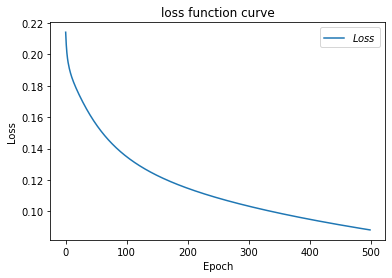

In [9]:
# 绘制 loss 曲线
plt.title('loss function curve') # picture title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_loss_results, label='$Loss$') # 逐点画出trian_loss_results值并连线，连线图标是Loss
plt.legend() # 画出曲线图标
plt.show()  # 画出图像

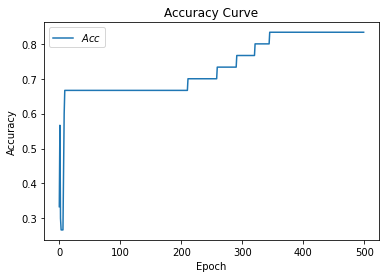

In [10]:
# 绘制 accuracy 曲线
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(test_acc, label='$ Acc $') # 逐点画出test_acc值并连线，连线图标是Accuracy
plt.legend()
plt.show()

In [11]:
test = np.array([[1,2,3],[2,3,4],[5,4,3],[8,7,2]])
test

array([[1, 2, 3],
       [2, 3, 4],
       [5, 4, 3],
       [8, 7, 2]])

In [12]:
tf.argmax(test,axis=0) #  竖着

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([3, 3, 1])>

In [13]:
tf.argmax(test,axis=1) # 横着

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([2, 2, 0, 0])>